우리는 '집단 지성(배깅, 랜덤 포레스트)'을 통해 안정적인 모델을 만드는 법을 배웠다. 5교시는 앙상블의 또 다른 축이자, 현대 머신러닝 경진대회(Kaggle 등)와 현업에서 가장 사랑받는 '부스팅(Boosting)' 알고리즘을 다룬다.

이 시간의 핵심은 "틀린 문제만 집중적으로 파고들어(오답 노트), 점수를 극한으로 끌어올리는 과정"을 이해하고, 그 정점에 있는 XGBoost와 LightGBM의 원리를 파악하는 것이다.

---

# 📘 [3차] 5.1. 앙상블 학습 2: 부스팅 (Boosting) - 오답에 집중하여 극한의 성능을 내다

## 1. 배깅과 부스팅: 협동의 방식이 다르다

앙상블 학습의 목표는 "여러 모델을 합쳐서 더 나은 결과를 만드는 것"이다. 하지만 그 합치는 방식에 따라 배깅(Bagging)과 부스팅(Boosting)으로 나뉜다. 이 둘의 차이를 명확히 이해하는 것이 중요하다.

### 1) 배깅(Bagging): 민주적인 투표 (병렬 처리)
앞서 배운 랜덤 포레스트가 대표적인 배깅 방식이다.
*   방식: 100명의 의사(모델)가 있다. 이들은 서로 상의하지 않는다. 각자 환자를 진료하고 독자적으로 진단을 내린다. 마지막에 다수결로 결정한다.
*   특징: 모델들이 '독립적(Independent)'이다. 동시에 학습할 수 있으므로 '병렬(Parallel)' 처리가 가능하다.
*   장점: 한두 명이 엉뚱한 소리를 해도 다수에 묻히므로 결과가 안정적이고 과적합이 잘 일어나지 않는다.

### 2) 부스팅(Boosting): 족집게 과외 (직렬 처리)
부스팅은 접근 방식이 완전히 다르다. 100명의 의사가 한 줄로 서서 이어달리기를 한다고 상상해 보자.
*   방식:
    1.  의사 A가 환자들을 진료한다. 쉬운 환자는 맞추고, 어려운 희귀병 환자는 틀린다.
    2.  의사 B는 의사 A가 '틀린 환자(오답)'만 넘겨받는다. "A가 이걸 놓쳤네? 나는 이 환자들을 집중적으로 공부해야지." 의사 B는 어려운 환자에 대해 가중치를 두고 학습한다.
    3.  의사 C는 의사 B조차도 틀린 '더 어려운 환자'들만 넘겨받아 공부한다.
    4.  마지막에는 이 모든 의사의 의견을 합친다. 단, 실력이 좋은(어려운 문제를 맞힌) 의사의 의견에 더 큰 가중치를 준다.
*   특징: 모델들이 서로 '의존적(Dependent)'이다. 앞사람이 끝나야 뒷사람이 공부할 수 있으므로 '직렬(Sequential)' 처리 방식이다.
*   장점: 앞사람의 실수를 계속 바로잡아 나가기 때문에, 배깅보다 정확도(Accuracy)가 훨씬 높다. 특히 어렵고 복잡한 패턴을 기가 막히게 찾아낸다.

---

## 2. 그래디언트 부스팅(GBM): 오차(Residual)를 사냥하라

부스팅의 핵심은 "앞선 모델의 실수를 어떻게 정의하고 수정할 것인가?"이다. 초기에는 단순히 틀린 데이터에 가중치를 주는 방식(AdaBoost)을 썼지만, 현대 머신러닝에서는 '오차(Residual)' 자체를 학습하는 그래디언트 부스팅(Gradient Boosting Machine, GBM)이 표준이 되었다.

### 1) 골프 퍼팅 비유
GBM이 정답을 찾아가는 과정은 골프 퍼팅과 매우 유사하다.
*   목표: 공을 홀컵(정답, $y$)에 넣는 것. (거리 100m)
*   1단계 (모델 1): 샷을 날린다. 80m를 갔다.
    *   남은 거리(오차): 20m.
*   2단계 (모델 2): 이제 목표는 홀컵(100m)이 아니다. '남은 거리 20m'를 보내는 것이 목표다. 샷을 날렸는데 15m를 갔다.
    *   남은 거리(오차): 5m.
*   3단계 (모델 3): 이제 목표는 '남은 거리 5m'이다. 살짝 쳐서 5m를 보냈다.
    *   남은 거리: 0m.
*   최종 결과: 모델 1(80m) + 모델 2(15m) + 모델 3(5m) = 100m (정답 도달)

### 2) 수학적 의미: 잔차 학습 (Residual Learning)
이를 데이터 분석 용어로 바꾸면 다음과 같다.
*   모델 A: $x$를 보고 $y$를 예측한다. 예측값 $\hat{y}_1$.
    *   오차(잔차) $r_1 = y - \hat{y}_1$.
*   모델 B: $x$를 보고 $y$가 아닌 $r_1$(오차)을 예측하도록 학습한다. 예측값 $\hat{y}_2$.
    *   남은 오차 $r_2 = r_1 - \hat{y}_2$.
*   모델 C: $x$를 보고 $r_2$(남은 오차)를 예측한다.
*   최종 예측: $\hat{y} = \hat{y}_1 + \hat{y}_2 + \hat{y}_3 + \dots$

즉, 그래디언트 부스팅은 정답을 한 번에 맞추려 하지 않는다. 남은 오차를 야금야금 깎아 먹는 방식으로 정답에 접근한다. 이때 오차를 줄이는 방향(Gradient)으로 이동한다고 하여 그래디언트 부스팅이라 부른다.
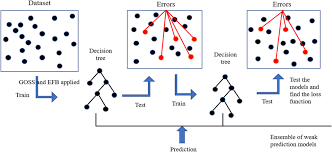
---

## 3. 부스팅의 양면성: 높은 성능과 과적합의 위험

부스팅은 헬스케어 데이터 분석에서 '양날의 검'과 같다.

### 1) 장점: 타의 추종을 불허하는 정확도
부스팅은 모델이 틀린 부분만 집요하게 파고든다.
*   랜덤 포레스트가 "대충 다수결로 합시다"라고 뭉뚱그리는 부분도, 부스팅은 "아니, 이 환자는 이런 특이한 패턴이 있어!"라고 찾아낸다.
*   따라서 암 진단, 사망률 예측 등 '높은 정확도가 생명인 분야'에서 랜덤 포레스트보다 더 우수한 성능을 보이는 경우가 많다. 데이터 경진대회 상위권은 대부분 부스팅 모델이 차지한다.

### 2) 단점: 과적합(Overfitting)과 노이즈 취약성
하지만 '오답에 집착한다'는 특성은 위험할 수 있다.
*   상황: 데이터 입력 오류로 인해 키가 3m인 환자 데이터(이상치/노이즈)가 있다고 치자.
*   랜덤 포레스트: "이건 이상한 데이터네. 무시하자." (다수결의 힘으로 상쇄됨)
*   부스팅: "어? 이 환자를 못 맞췄네? 다음 모델은 무조건 이 3m를 맞추도록 학습해!"
    *   모델이 이상치 하나를 맞추기 위해 수식을 억지로 비틀어버린다.
    *   결과적으로 학습 데이터 점수는 100점이지만, 일반적인 환자가 왔을 때 엉뚱한 예측을 하는 과적합 상태가 되기 쉽다.

그래서 부스팅을 사용할 때는 '적당히 하다가 멈추는 기술(조기 종료)'과 '너무 튀지 않게 막는 기술(규제)'이 필수적이다.

---

## 4. XGBoost와 LightGBM

전통적인 GBM은 성능은 좋지만 학습 속도가 너무 느렸다(직렬 처리니까). 이를 획기적으로 개선하여 전 세계를 휩쓴 두 가지 라이브러리가 있다.

### 1) XGBoost (eXtreme Gradient Boosting): 부동의 1위
이름 그대로 '극한'의 성능을 추구한 모델이다.
*   규제(Regularization) 내장: GBM에 없던 규제 기능(L1, L2)을 추가하여 과적합을 강력하게 억제한다.
*   결측치 자동 처리: 헬스케어 데이터에는 빈칸(NaN)이 많다. XGBoost는 학습 과정에서 "값이 비어있을 때는 왼쪽 가지로 가는 게 이득인지 오른쪽이 이득인지"까지 스스로 학습한다. 전처리의 수고를 덜어주는 엄청난 장점이다.
*   속도 개선: 트리 생성을 병렬로 처리하는 기술을 도입하여 기존 GBM보다 훨씬 빠르다.
*   위상: "머신러닝 대회의 우승 공식"이라고 불릴 정도로 신뢰성이 높다.

#### 1. XGBoost의 정의와 탄생 배경
XGBoost(eXtreme Gradient Boosting)는 이름 그대로 '극한(Extreme)'의 성능을 목표로 설계된 그레디언트 부스팅(Gradient Boosting)의 확장판이다. 기존의 그레디언트 부스팅 모델은 성능은 뛰어났으나, 학습 속도가 매우 느리고 과적합(Overfitting)에 취약하다는 단점이 있었다. 이를 수학적 알고리즘 개선과 시스템 최적화를 통해 해결하여 현재 머신러닝 경진대회와 실무에서 가장 압도적인 성능을 보여주는 도구가 되었다.

#### 2. 핵심 작동 원리: 어떻게 모델이 구성되는가?

XGBoost는 여러 개의 의사결정나무(Decision Tree)를 순차적으로 쌓아 올리는 가법 모델(Additive Model) 방식을 취한다.

##### 2.1. 잔차 학습 (Learning from Residuals)
가장 핵심적인 구성 방식은 정답을 맞히는 것이 아니라, '앞선 나무가 틀린 오차(잔차)'를 다음 나무가 학습하는 것이다.
1.  첫 번째 나무: 환자의 데이터를 보고 질병 유무를 대략적으로 예측한다. 당연히 오차가 발생한다.
2.  두 번째 나무: 원본 정답이 아니라, '첫 번째 나무가 틀린 만큼의 오차'를 정답으로 삼아 학습한다.
3.  세 번째 나무: 첫 번째와 두 번째 나무를 합쳤을 때 여전히 남아있는 '미세한 오차'를 다시 학습한다.
4.  최종 결합: 이 수많은 나무의 예측치를 모두 더하여 최종 결론을 내린다.

##### 2.2. 그레디언트(Gradient)의 활용
XGBoost는 오차를 줄이기 위해 경사하강법(Gradient Descent)의 원리를 사용한다. 현재 모델의 오차가 어느 방향으로 줄어드는지(미분값)를 계산하여, 다음 나무가 그 방향으로 정확하게 자라나도록 가이드한다.

#### 3. XGBoost가 '극한(Extreme)'인 이유 (차별점)

단순한 부스팅 모델을 넘어 XGBoost가 헬스케어 분석에서 특히 강력한 이유는 다음과 같은 내부 구성 요소들 때문이다.

##### 3.1. 내장된 규제 (Regularization) - 과적합 방지
기존 부스팅과 달리 XGBoost는 모델의 복잡도를 제어하는 L1(Lasso), L2(Ridge) 규제 기능이 수식 안에 포함되어 있다. 이는 나무가 너무 복잡하게 자라나 학습 데이터를 '암기'해버리는 현상을 원천적으로 차단한다. 헬스케어 데이터는 노이즈가 많기 때문에 이 규제 기능이 일반화 성능을 크게 높여준다.

##### 3.2. 결측치 자동 처리 (Missing Value Handling)
의료 데이터(EMR)에는 검사 누락 등으로 인한 결측치(NaN)가 매우 빈번하다. XGBoost는 나무를 뻗어 나갈 때, 특정 변수가 비어있는 경우 "이 데이터는 왼쪽으로 가는 게 나을까, 오른쪽으로 가는 게 나을까?"를 학습 과정에서 스스로 시도해보고 최적의 경로를 결정한다. 따라서 분석가가 일일이 빈칸을 채우는 수고를 덜어준다.

##### 3.3. 시스템 최적화: 병렬 처리와 가지치기
*   병렬 학습: CPU의 모든 코어를 동시에 사용하여 나무를 구성하기 때문에 대용량 유전체 데이터나 청구 데이터도 빠르게 처리한다.
*   전략적 가지치기: 'Max Depth'까지 일단 나무를 다 키운 뒤, 이득(Gain)이 음수인 가지들을 뒤에서부터 쳐내는 방식을 사용하여 훨씬 효율적인 나무 구조를 만든다.

#### 4. 헬스케어 적용 시나리오 비유

이 과정을 병원에서의 '다학제 진료팀(Multidisciplinary Team)'에 비유할 수 있다.

1.  (첫 번째 나무): 환자의 기본 차트를 보고 일반적인 소견을 낸다. (정확도 낮음)
2.  (두 번째 나무): 레지던트가 놓친 미세한 증상(오차)들만 집중적으로 분석하여 처방을 보강한다.
3.  (세 번째 나무): 앞선 두 의사가 모두 헷갈려 하는 아주 희귀한 패턴(남은 오차)을 잡아내어 최종 결론을 확정한다.

이처럼 오답 노트를 공유하며 한 팀으로 움직이는 구조 덕분에, XGBoost는 복잡하게 얽힌 환자의 생체 지표 사이에서 치명적인 질병 패턴을 가장 정교하게 찾아내는 모델이 된다.

#### 5. 요약
XGBoost는 단순히 나무를 많이 만드는 모델이 아니다. 규제(Regularization)를 통해 스스로 절제하고, 그레디언트(Gradient)를 통해 오차의 핵심을 파고들며, 결측치를 스스로 대처하는 지능적인 앙상블 시스템이다. 이러한 구조적 정교함 덕분에 데이터 양이 충분한 의료 인공지능 연구에서 가장 신뢰받는 알고리즘으로 자리 잡고 있다.

### 2) LightGBM (Light Gradient Boosting Machine): 가볍고 빠르다
XGBoost도 데이터가 수십만 건, 수백만 건(유전체 데이터, 보험 청구 데이터)이 되면 느려진다. 이에 대항마로 나온 것이 MS의 LightGBM이다.
*   리프 중심 성장 (Leaf-wise):
    *   대부분의 트리는 균형을 맞추며 층별로(Level-wise) 자란다.
    *   LightGBM은 균형을 무시하고, 오차를 가장 많이 줄일 수 있는 잎(Leaf) 하나만 골라서 깊게 파고든다. 비대칭적인 나무가 만들어진다.
*   장점: 학습 속도가 XGBoost보다 훨씬 빠르고 메모리를 적게 차지한다. 대용량 데이터에서 압도적인 효율을 보여준다.
*   주의점: 데이터가 너무 적으면(1만 건 이하) 과적합되기 쉽다. 깊게 파고드는 특성 때문이다.

#### 1. LightGBM의 정의와 특징
LightGBM(Light Gradient Boosting Machine)은 마이크로소프트(MS)에서 개발한 고성능 그레디언트 부스팅 프레임워크이다. 기존 부스팅 모델들이 데이터가 커질수록 학습 속도가 기하급수적으로 느려지는 한계를 극복하기 위해 설계되었다. 특히 메모리 사용량이 적고 학습 속도가 매우 빨라, 수백만 건 이상의 대규모 헬스케어 데이터를 다룰 때 필수적으로 선택되는 알고리즘이다.

#### 2. 핵심 작동 원리: 어떻게 기존 모델과 다른가?

LightGBM이 '가볍고 빠른' 이유는 나무를 키우는 방식과 데이터를 처리하는 방식이 기존 모델(XGBoost 포함)과 완전히 다르기 때문이다.

##### 2.1. 리프 중심 성장 (Leaf-wise Growth)
가장 결정적인 차별점은 나무의 모양을 만드는 방식이다.
*   기존 방식 (Level-wise): 나무가 양쪽 균형을 맞추며 층별로 차근차근 자란다. 규칙적이지만, 오차를 줄이는 데 큰 도움이 안 되는 가지까지 모두 생성하느라 시간과 자원을 낭비한다.
*   LightGBM 방식 (Leaf-wise): 전체 균형을 무시하고, '오차를 가장 많이 줄일 수 있는 잎(Leaf) 노드' 하나만 골라 그 방향으로만 깊게 파고든다.
*   효과: 불필요한 계산을 획기적으로 줄이면서도, 더 정교하게 오차를 사냥한다. 비대칭적이지만 매우 효율적인 나무 구조가 만들어진다.

##### 2.2. GOSS (Gradient-based One-Side Sampling)
모든 환자 데이터를 똑같이 중요하게 취급하지 않는다.
*   이미 예측이 잘 된 데이터(그레디언트가 작은 데이터)는 학습 기여도가 낮다.
*   LightGBM은 '아직 잘 못 맞추고 있는 환자(그레디언트가 큰 데이터)'를 우선적으로 선택하고, 잘 맞추고 있는 환자들은 일부만 무작위로 샘플링하여 학습에 사용한다.
*   효과: 데이터 양을 대폭 줄이면서도 정보 손실을 최소화하여 학습 속도를 높인다.

##### 2.3. EFB (Exclusive Feature Bundling)
변수가 너무 많을 때 이를 압축하는 기술이다.
*   의료 데이터에는 '특정 희귀 질환 유무'처럼 대부분이 0인 변수들이 많다.
*   LightGBM은 서로 동시에 나타나지 않는(상호 배타적인) 변수들을 하나의 묶음으로 합쳐버린다.
*   효과: 변수의 개수(차원)를 줄여 연산량을 감소시킨다.

#### 3. 헬스케어 적용 시나리오 비유: '응급 선별 진료'

이 과정을 병원 '응급실의 트리아제(Triage, 환자 분류)'에 비유할 수 있다.

1.  Level-wise(기존): 응급실에 온 모든 환자를 순서대로, 똑같은 정밀도로 검사한다. 경증 환자를 검사하느라 정작 위급한 중증 환자를 놓칠 수 있고 시간이 오래 걸린다.
2.  Leaf-wise(LightGBM): 딱 봐도 상태가 가장 안 좋은(오차가 큰) 환자 한 명을 지목하고, 그 환자의 원인을 깊게 파고든다. 다른 가지(환자)는 나중에 본다.
3.  효과: 가장 시급한 문제(오차)부터 빠르게 해결하므로 짧은 시간 안에 최고의 생존율(정확도)을 뽑아낼 수 있다.

#### 4. 헬스케어 데이터 분석 시 주의사항

LightGBM은 강력하지만, 헬스케어 전공자가 특히 주의해야 할 점이 있다.

*   과적합(Overfitting) 위험: 나무가 한쪽 방향으로만 깊게 자라기 때문에, 데이터 양이 적으면(보통 10,000건 이하) 특정 환자 패턴에 너무 과하게 집착하는 과적합이 발생하기 쉽다.
*   데이터 규모의 선택: 환자 수가 수십만 명에 달하는 국가 보건 의료 빅데이터나 유전체 데이터에는 LightGBM이 유리하지만, 수십 명 단위의 소규모 임상 실험 데이터에는 오히려 랜덤 포레스트나 일반 선형 모델이 더 안정적일 수 있다.

#### 5. 요약
LightGBM은 비대칭적인 깊은 학습(Leaf-wise)과 지능적인 데이터 압축(GOSS, EFB)을 통해 속도와 성능을 동시에 잡은 알고리즘이다. 실시간 생체 신호 모니터링이나 국가 단위의 질병 예측 시스템처럼 '방대한 데이터'와 '빠른 의사결정'이 요구되는 현대 헬스케어 IT 환경에서 가장 주목받는 기술이다.


---

## 5. 하이퍼파라미터: 부스팅을 제어하는 조종간

부스팅 모델은 랜덤 포레스트보다 다뤄야 할 설정값(하이퍼파라미터)이 많고 민감하다. 헬스케어 분석가가 꼭 알아야 할 핵심 파라미터는 다음과 같다.

### 1) 학습률 (Learning Rate)
*   의미: 오차를 얼마나 수정할 것인가? (보폭의 크기)
    *   값이 크면(0.5): 성큼성큼 수정한다. 빠르지만 최적점을 지나칠 수 있다.
    *   값이 작으면(0.01): 아주 조금씩 세밀하게 수정한다. 느리지만 정교하다.
*   전략: 보통 학습률을 낮게 잡고(0.01~0.05), 대신 반복 횟수(n_estimators)를 늘리는 것이 성능이 좋다. "천천히 오랫동안 공부하는 것"이 벼락치기보다 낫다.

### 2) 조기 종료 (Early Stopping)
*   의미: "더 이상 실력이 늘지 않으면 공부를 그만둬라."
    *   `n_estimators=1000`으로 설정했더라도, 100번 반복하는 동안 검증 세트의 점수가 좋아지지 않으면 101번째에서 멈춘다.
    *   과적합을 막고 시간을 절약하는 필수 기능이다.

---

## 6. 요약:

1.  부스팅(Boosting): 여러 모델을 직렬로 연결하여, 앞선 모델의 오차(Residual)를 뒤따르는 모델이 수정해 나가는 방식이다.
2.  특징: 배깅(랜덤 포레스트)보다 정확도가 높지만, 노이즈에 민감하고 과적합 위험이 크다.
3.  XGBoost: 규제 기능과 결측치 처리 능력을 갖춘 가장 강력하고 범용적인 부스팅 라이브러리다.
4.  LightGBM: 대용량 데이터에서 학습 속도가 매우 빠르다. 단, 데이터가 너무 적으면 과적합될 수 있다.
5.  전략: 처음에는 안정적인 랜덤 포레스트로 베이스라인을 잡고, 성능을 더 끌어올려야 할 때 XGBoost나 LightGBM을 튜닝하며 적용하는 것이 정석이다.

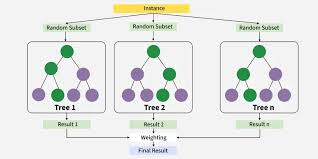

## 5.2. \[예제 1\] 부스팅의 원리: 잔차(오차) 맞추기 시각화

부스팅이 어떻게 오차를 줄여가며 복잡한 데이터를 맞추는지, 단순한 회귀
문제로 시각화해 봅니다.

상황: 구불구불한 2차 곡선 형태의 데이터를 3개의 단순한 결정
트리(Weak Learner)가 이어달리기하며 맞추는 과정.

``` python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# 1. 데이터 생성 (2차 곡선 + 노이즈)
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100) # y = 3x^2 + noise

# 2. 첫 번째 예측기 (Tree 1)
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

# 3. 잔차(Residual) 계산 및 두 번째 예측기 (Tree 2)
# Tree 2는 y가 아니라, (y - tree1의 예측값)을 학습한다.
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

# 4. 잔차 계산 및 세 번째 예측기 (Tree 3)
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

# 5. 최종 모델 (모든 예측값 합치기)
X_new = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred_sum = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

# 6. 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(X, y, "b.", markersize=3)
plt.plot(X_new, tree_reg1.predict(X_new), "g-", label="Tree 1", linewidth=2)
plt.title("Step 1: First Model")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X, y, "b.", markersize=3)
plt.plot(X_new, y_pred_sum, "r-", label="Ensemble (Tree 1+2+3)", linewidth=2)
plt.title("Step 3: Final Model (Sum of 3 Trees)")
plt.legend()

plt.show()

# 설명:
# 왼쪽 그림(Tree 1)은 데이터를 대충 계단식으로 맞춥니다.
# 오른쪽 그림(Ensemble)은 뒤따르는 트리들이 오차를 보정해준 덕분에
# 데이터의 곡선 형태를 훨씬 정교하게 따라가는 것을 볼 수 있습니다.
```


> 📖 가이드
>
> 부스팅(Boosting)이 오답(오차)을 줄여나가는 과정을 눈으로 확인합니다.
> - Weak Learner: 아주 단순한 모델(깊이가 얕은 트리) 하나는 데이터를 잘 맞추지 못합니다.
> - Residual Fitting: 첫 번째 모델이 틀린 오차(잔차)를 두 번째 모델이 예측하고, 그 오차를 세 번째 모델이 또 예측합니다.
> - Ensemble: 이들을 모두 합치면 복잡한 곡선도 정교하게 따라가는 강력한 모델이 됩니다.



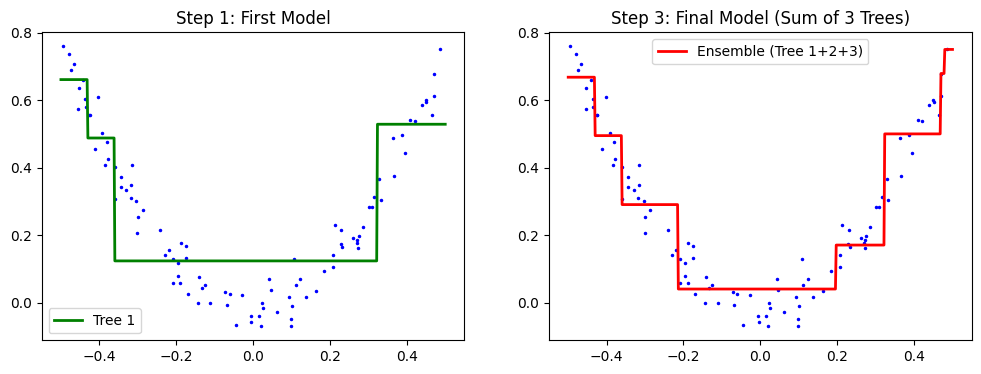

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# 1. 데이터 생성 (2차 곡선 + 노이즈)
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100) # y = 3x^2 + noise

# 2. 첫 번째 예측기 (Tree 1)
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

# 3. 잔차(Residual) 계산 및 두 번째 예측기 (Tree 2)
# Tree 2는 y가 아니라, (y - tree1의 예측값)을 학습한다.
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

# 4. 잔차 계산 및 세 번째 예측기 (Tree 3)
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

# 5. 최종 모델 (모든 예측값 합치기)
X_new = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred_sum = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

# 6. 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(X, y, "b.", markersize=3)
plt.plot(X_new, tree_reg1.predict(X_new), "g-", label="Tree 1", linewidth=2)
plt.title("Step 1: First Model")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X, y, "b.", markersize=3)
plt.plot(X_new, y_pred_sum, "r-", label="Ensemble (Tree 1+2+3)", linewidth=2)
plt.title("Step 3: Final Model (Sum of 3 Trees)")
plt.legend()

plt.show()

## 5.3. \[예제 2\] 랜덤 포레스트 vs 그레디언트 부스팅 성능 비교

Scikit-learn에 내장된 기본적인 `GradientBoostingClassifier`를 사용하여
랜덤 포레스트와 비교해 봅니다.

상황: 유방암 진단 데이터셋의 정확도 대결.

``` python
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. 데이터 로드
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=42)

# 2. 랜덤 포레스트 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print(f"Random Forest 정확도: {rf.score(X_test, y_test):.4f}")

# 3. 그레디언트 부스팅 학습
# learning_rate: 학습률. 작을수록 오차를 조금씩 천천히 수정함 (성능 좋아짐, 속도 느려짐)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)
print(f"Gradient Boosting 정확도: {gb.score(X_test, y_test):.4f}")

# 설명:
# 일반적으로 데이터가 복잡할수록 부스팅(GB)이 랜덤 포레스트보다 조금 더 높은 정확도를 보입니다.
# 다만 학습 시간은 배깅(RF)이 병렬 처리가 되어 더 빠를 수 있습니다.
```


> 📖 가이드
>
> GBM(Gradient Boosting Machine)과 랜덤 포레스트의 성능을 비교합니다.
> - 정확도: 부스팅은 오차를 집요하게 파고들기 때문에 일반적으로 랜덤 포레스트보다 정확도가 높습니다.
> - 속도: 하지만 트리를 하나씩 순서대로(직렬) 만들어야 해서 속도는 더 느릴 수 있습니다.



In [ ]:
# do write code
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. 데이터 로드
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=42)

# 2. 랜덤 포레스트 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print(f"Random Forest 정확도: {rf.score(X_test, y_test):.4f}")

# 3. 그레디언트 부스팅 학습
# learning_rate: 학습률. 작을수록 오차를 조금씩 천천히 수정함 (성능 좋아짐, 속도 느려짐)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)
print(f"Gradient Boosting 정확도: {gb.score(X_test, y_test):.4f}")

Random Forest 정확도: 0.9650
Gradient Boosting 정확도: 0.9580


## 5.4. \[예제 3\] XGBoost 입문:

최고의 성능을 자랑하는  XGBoost 라이브러리를 직접 사용해보고, 결측치를
자동으로 처리하는 강력함을 확인한다.

상황: 결측치가 포함된 당뇨병 환자 데이터 분류.

``` python
# XGBoost 설치 (Colab에는 기본 설치됨)
!pip install xgboost

import xgboost as xgb
import pandas as pd
from sklearn.datasets import load_diabetes # 이건 회귀용이지만 분류로 변환해서 사용

# 1. 데이터 준비 (당뇨 수치를 이진 분류로 변환: 평균 이상이면 1, 아니면 0)
diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = (diabetes.target > np.mean(diabetes.target)).astype(int)

# 2. 강제로 결측치(NaN) 생성 (XGBoost의 처리 능력 확인용)
# bmi 컬럼의 10%를 NaN으로 만듦
X.loc[X.sample(frac=0.1).index, 'bmi'] = np.nan

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. XGBoost 모델 학습
# use_label_encoder=False, eval_metric='logloss': 경고 메시지 방지용
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

# 4. 평가
acc = accuracy_score(y_test, xgb_clf.predict(X_test))
print(f"XGBoost 정확도 (결측치 포함): {acc:.4f}")

# 5. 변수 중요도 시각화
xgb.plot_importance(xgb_clf, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

# 설명:
# 별도의 Imputation(결측치 채우기) 없이 NaN이 있는 채로 넣었음에도 에러 없이 잘 학습합니다.
# XGBoost는 학습 시 "값이 비어있으면 왼쪽 가지로 갈지 오른쪽으로 갈지"까지 스스로 학습하기 때문입니다.
```


> 📖 가이드
>
> 현대 머신러닝의 제왕 XGBoost를 사용해봅니다.
> - 결측치 처리: 데이터 중간에 구멍(NaN)이 뚫려 있어도, XGBoost는 "어느 쪽으로 보내는 게 이득인지" 스스로 학습하여 에러 없이 처리합니다.
> - Feature Importance: 어떤 변수가 중요한지 시각화하여 보여줍니다.



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:57:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost 정확도 (결측치 포함): 0.7303


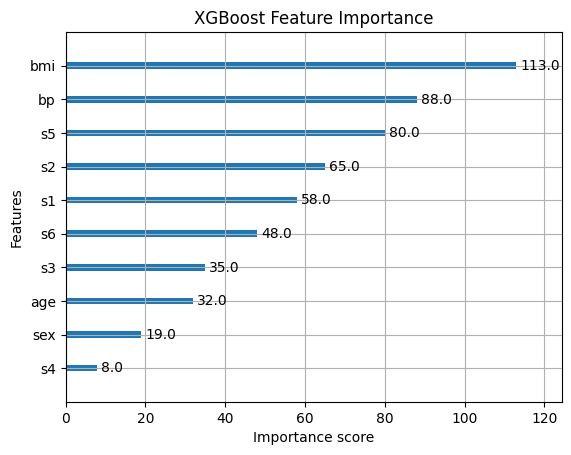

In [ ]:
# do write code
!pip install xgboost

import xgboost as xgb
import pandas as pd
from sklearn.datasets import load_diabetes # 이건 회귀용이지만 분류로 변환해서 사용

# 1. 데이터 준비 (당뇨 수치를 이진 분류로 변환: 평균 이상이면 1, 아니면 0)
diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = (diabetes.target > np.mean(diabetes.target)).astype(int)

# 2. 강제로 결측치(NaN) 생성 (XGBoost의 처리 능력 확인용)
# bmi 컬럼의 10%를 NaN으로 만듦
X.loc[X.sample(frac=0.1).index, 'bmi'] = np.nan

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. XGBoost 모델 학습
# use_label_encoder=False, eval_metric='logloss': 경고 메시지 방지용
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

# 4. 평가
acc = accuracy_score(y_test, xgb_clf.predict(X_test))
print(f"XGBoost 정확도 (결측치 포함): {acc:.4f}")

# 5. 변수 중요도 시각화
xgb.plot_importance(xgb_clf, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

## 5.5. \[예제 4\] LightGBM과 조기 종료 (Early Stopping)

대용량 데이터에서 빠른 속도를 자랑하는 LightGBM을 사용하고, 과적합을
막는 조기 종료 기법을 실습합니다.

상황: 학습을 1000번 반복하라고 시켰지만, 성능이 안 오르면 중간에
멈추게 하기.

``` python
# LightGBM 설치
!pip install lightgbm


from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation

# 1. LightGBM 모델 생성
# n_estimators=1000: 최대 1000번까지 공부(부스팅)해라.
lgbm = LGBMClassifier(n_estimators=1000, learning_rate=0.05, random_state=42)

# 2. 조기 종료를 위한 학습 (Fit with Early Stopping)
# eval_set: 검증용 데이터 (모의고사)
# early_stopping_rounds=10: 모의고사 점수가 10번 연속으로 안 오르면 공부를 그만둬라.
# (과적합 방지 및 시간 절약)
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss',
    callbacks=[
        from lightgbm import early_stopping, log_evaluation
        early_stopping(stopping_rounds=10),
        log_evaluation(period=50)  # 50번마다 로그 출력
    ]
)

# 3. 최종 성능
print(f"\n최적의 트리 개수: {lgbm.best_iteration_}")
print(f"LightGBM 정확도: {accuracy_score(y_test, lgbm.predict(X_test)):.4f}")

# 설명:
# 1000번을 다 돌지 않고, 성능 향상이 멈추는 시점(예: 150번 쯤)에서 자동으로 멈춥니다.
# 헬스케어 데이터는 노이즈가 많아 너무 오래 학습하면 오히려 성능이 떨어지는데, 이를 막아줍니다.
```


> 📖  가이드
>
> 대용량 데이터 처리에 특화된 LightGBM과 조기 종료(Early Stopping)를 배웁니다.
> - LightGBM: 속도가 매우 빠르고 메모리를 적게 씁니다.
> - Early Stopping: "더 이상 실력이 안 느는 것 같으면 공부를 그만해라"라고 명령합니다. 과적합을 막고 학습 시간을 단축하는 필수 테크닉입니다.



In [ ]:
# do write code
!pip install lightgbm

from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation # Moved import statement here

# 1. LightGBM 모델 생성
# n_estimators=1000: 최대 1000번까지 공부(부스팅)해라.
lgbm = LGBMClassifier(n_estimators=1000, learning_rate=0.05, random_state=42)

# 2. 조기 종료를 위한 학습 (Fit with Early Stopping)
# eval_set: 검증용 데이터 (모의고사)
# early_stopping_rounds=10: 모의고사 점수가 10번 연속으로 안 오르면 공부를 그만둬라.
# (과적합 방지 및 시간 절약)
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss',
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=50)  # 50번마다 로그 출력
    ]
)

# 3. 최종 성능
print(f"\n최적의 트리 개수: {lgbm.best_iteration_}")
print(f"LightGBM 정확도: {accuracy_score(y_test, lgbm.predict(X_test)):.4f}")

[LightGBM] [Info] Number of positive: 156, number of negative: 197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 353, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.441926 -> initscore=-0.233348
[LightGBM] [Info] Start training from score -0.233348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

## 5.6. \[예제 5\] 불균형 데이터 처리 (Scale Pos Weight)

희귀 질환 데이터(불균형)를 다룰 때, 부스팅 알고리즘이 제공하는 가중치
옵션을 사용하여 성능을 높입니다.

상황: 암 환자가 10%뿐인 불균형 데이터에서 재현율(Recall) 높이기.

``` python
from sklearn.metrics import classification_report

# 1. 불균형 데이터 생성
from sklearn.datasets import make_classification
X_imb, y_imb = make_classification(n_samples=1000, weights=[0.9, 0.1], random_state=42)
X_train_ib, X_test_ib, y_train_ib, y_test_ib = train_test_split(X_imb, y_imb, random_state=42)

# 2. 일반 XGBoost
xgb_normal = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_normal.fit(X_train_ib, y_train_ib)

# 3. 가중치 적용 XGBoost (scale_pos_weight)
# 값 설정 공식: (음성 샘플 수) / (양성 샘플 수) -> 대략 9배
ratio = float(np.sum(y_train_ib == 0)) / np.sum(y_train_ib == 1)
xgb_weighted = xgb.XGBClassifier(scale_pos_weight=ratio, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_weighted.fit(X_train_ib, y_train_ib)

# 4. 결과 비교
print("=== 일반 XGBoost ===")
print(classification_report(y_test_ib, xgb_normal.predict(X_test_ib)))

print(f"\n=== 가중치 적용 XGBoost (Weight={ratio:.1f}) ===")
print(classification_report(y_test_ib, xgb_weighted.predict(X_test_ib)))

# 설명:
# 가중치를 적용한 모델(Weighted)이 소수 클래스(1)에 대한 Recall(재현율)이 훨씬 높게 나옵니다.
# SMOTE 같은 샘플링 없이도 모델 파라미터만으로 불균형 문제를 완화할 수 있습니다.
```


> 📖  가이드
>
> 암 환자가 극히 적은 불균형 데이터(Imbalanced Data) 문제를 부스팅으로 해결합니다.
> - scale_pos_weight: 소수 클래스(암 환자)를 틀렸을 때 더 큰 벌점을 주도록 설정합니다.
> - 효과: 데이터 뻥튀기(오버샘플링) 없이도, 모델이 소수 클래스를 더 잘 찾아내게(Recall 증가) 만듭니다.



In [ ]:
# do write code
from sklearn.metrics import classification_report

# 1. 불균형 데이터 생성
from sklearn.datasets import make_classification
X_imb, y_imb = make_classification(n_samples=1000, weights=[0.9, 0.1], random_state=42)
X_train_ib, X_test_ib, y_train_ib, y_test_ib = train_test_split(X_imb, y_imb, random_state=42)

# 2. 일반 XGBoost
xgb_normal = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_normal.fit(X_train_ib, y_train_ib)

# 3. 가중치 적용 XGBoost (scale_pos_weight)
# 값 설정 공식: (음성 샘플 수) / (양성 샘플 수) -> 대략 9배
ratio = float(np.sum(y_train_ib == 0)) / np.sum(y_train_ib == 1)
xgb_weighted = xgb.XGBClassifier(scale_pos_weight=ratio, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_weighted.fit(X_train_ib, y_train_ib)

# 4. 결과 비교
print("=== 일반 XGBoost ===")
print(classification_report(y_test_ib, xgb_normal.predict(X_test_ib)))

print(f"\n=== 가중치 적용 XGBoost (Weight={ratio:.1f}) ===")
print(classification_report(y_test_ib, xgb_weighted.predict(X_test_ib)))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:00:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:00:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== 일반 XGBoost ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       226
           1       0.88      0.62      0.73        24

    accuracy                           0.96       250
   macro avg       0.92      0.81      0.85       250
weighted avg       0.95      0.96      0.95       250


=== 가중치 적용 XGBoost (Weight=8.5) ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       226
           1       0.89      0.71      0.79        24

    accuracy                           0.96       250
   macro avg       0.93      0.85      0.89       250
weighted avg       0.96      0.96      0.96       250

